# Train Dynamics

In [6]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from offroad.utils import load_state
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point, calc_delta_v
from car_dynamics.envs import make_env, KinematicBicycleModel, KinematicParams
from car_dynamics.models_torch import MLP, train_MLP_pipeline
from rich.progress import track
import pandas as pd
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

LF = .16
LR = .15
L = LF+LR
H = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE", DEVICE)

DEVICE cpu


## Visualize Loss Curve

/home/wenli-run/car_collect/tmp/H20-BS1024-E10000-LR0.001-model.pt


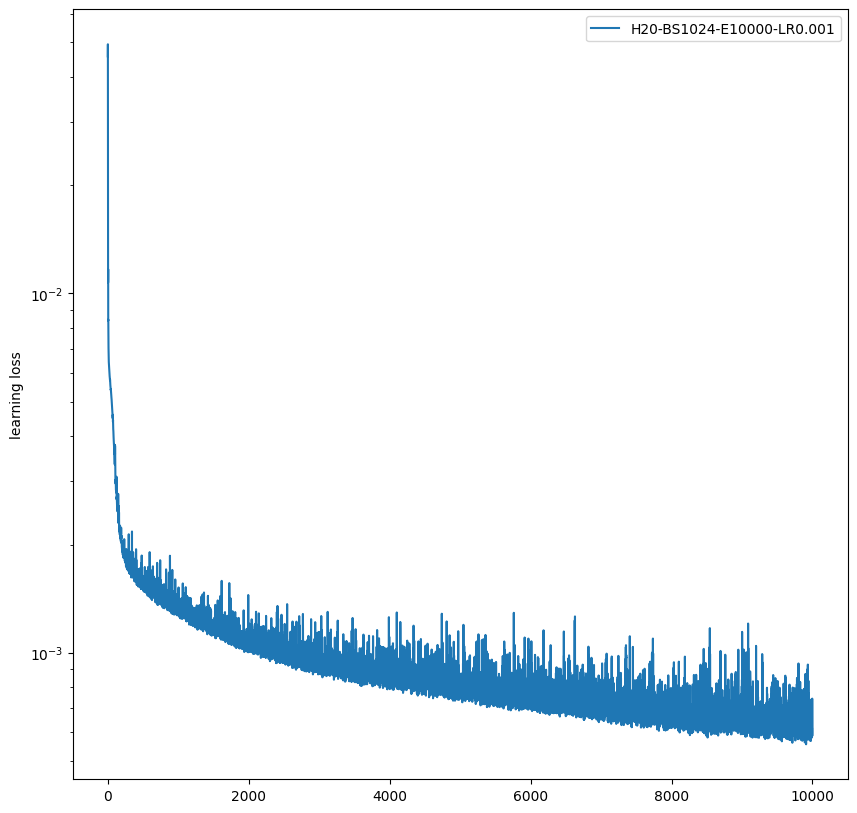

In [8]:
plt.subplots(figsize=(10,10))
for H in [20]:
    for BATCH_SIZE in [1024]:
        for NUM_EPOCHS in [10000]:
            for LR in [0.001]:
                EXP_DIR = f"H{H}-BS{BATCH_SIZE}-E{NUM_EPOCHS}-LR{LR}"
                loss_dir = f'/home/wenli-run/car_collect/tmp/{EXP_DIR}-log.txt'
                model_dir = f'/home/wenli-run/car_collect/tmp/{EXP_DIR}-model.pt'
                loss = np.loadtxt(loss_dir)
                plt.plot(loss, label=EXP_DIR)
                print(model_dir)
plt.yscale('log')
plt.ylabel('learning loss')
plt.legend()

## Evaluate

## LOAD DATA

## Visualize Open Loop Trajectory

In [4]:
log_dir = '/Users/wenlixiao/Desktop/offroad/data/data-20240118-151208'
t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0,6], orientation_provider="NONE")
obs_np = p_dict['obs']

def plot(N=0, H=20, K=40, zoom_x0=-2, zoom_x1=4,zoom_y0=-2, zoom_y1=4, kbm=False, 
         birdview=False, real_psi=False,real_v=False, atan2=False,
        psi_factor=1.53):
    
    dt = 0.125

    ############## Load trained Model ##############################################
    model_dir = f'/Users/wenlixiao/Desktop/offroad/tmp/H20-BS1024-E10000-LR0.001-model.pt'
    model = MLP(input_size=6*H, hidden_size=128, output_size=3)
    model.load(model_dir)
    model.to(DEVICE)

    ############# Baseline: Kinematic Bicycle Model #################
    model_params = KinematicParams(
                    num_envs=1,
                    last_diff_vel=torch.zeros([1, 1]).to(DEVICE),
                    KP_VEL=7.,
                    KD_VEL=.02,
                    MAX_VEL=8.,
                    PROJ_STEER=.48,
                  SHIFT_STEER=-.08,
                    DT=dt,
    )   
    dynamics = KinematicBicycleModel(model_params, device=DEVICE)

    ################################################################
    plt.plot(obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 0], obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 1], alpha=0.1)

    real_k_trajectory = obs_np[N:N+K+1]
    action_k_trajectory = action_list[N:N+K+1]
    plt.scatter(real_k_trajectory[:, 0], real_k_trajectory[:, 1], marker='o', s=5, color='red', alpha=0.5, label='real trajectory')

    # Predict k steps
    obs_init = real_k_trajectory[0, :4]
    pred_k_trajectory = real_k_trajectory[0:H, :4].tolist()
    pred_k_trajectory_kbm = real_k_trajectory[0:H, :4].tolist()
    for i in range(H-1, len(action_k_trajectory)-1):
        state_hist = np.array(pred_k_trajectory[-H:])[:,:4]
        old_obs = torch.Tensor(np.concatenate((state_hist,action_k_trajectory[i-H+1:i+1,:2]),axis=1).flatten()).unsqueeze(0)
        # print("old_obs shape", old_obs.shape)
        new_beta_norm = model.predict(old_obs.to(DEVICE)).squeeze().detach().cpu().numpy()
        # new_vel_inc = model_vel.predict(old_obs.to(DEVICE)).squeeze().detach().cpu().numpy()
        new_vel_inc = new_beta_norm[2]
        new_beta = np.arctan2(new_beta_norm[1], new_beta_norm[0])
        # print("beta output", new_beta_norm, new_beta)
        psi = pred_k_trajectory[-1][2]
        x = pred_k_trajectory[-1][0]
        y = pred_k_trajectory[-1][1]
        v = pred_k_trajectory[-1][3]
        # v = real_k_trajectory[i, 3]
        if real_psi:
            psi = real_k_trajectory[i, 2]
        next_x = x + np.cos(psi + new_beta) * dt * v
        next_y = y + np.sin(psi + new_beta) * dt * v
        if atan2:
            next_delta = np.arctan2(L*np.tan(new_beta), LR)
        else:
            next_delta = np.arctan(L*np.tan(new_beta)/LR)
        next_psi = psi + v*np.cos(new_beta)/L*np.tan(next_delta) * dt / psi_factor
        if real_v:
            next_v = real_k_trajectory[i+1, 3]
        else:
            next_v = v + new_vel_inc
        new_obs = np.array([next_x,next_y,next_psi, next_v])
        pred_k_trajectory.append(new_obs)

        ## KBM
        new_obs_kbm = dynamics.single_step_numpy(np.array(pred_k_trajectory_kbm[-1]), action_k_trajectory[i])
        # new_obs_kbm[3] = real_k_trajectory[i+1, 3]
        pred_k_trajectory_kbm.append(new_obs_kbm)
        ####

        #Add visualization for KBM prediction
    pred_k_trajectory = np.array(pred_k_trajectory)
    plt.scatter(pred_k_trajectory[H:, 0], pred_k_trajectory[H:, 1], marker='x', s=10, color='green', alpha=0.5, label='NN predict trajectory')

    # # MPPI Trajectory
    # action_N_mppi = mppi_actions[N]
    # mppi_k_trajectory = [obs_init]
    # for a_mppi in action_N_mppi:
    #     new_obs = dynamics.single_step_numpy(mppi_k_trajectory[-1], a_mppi)
    #     mppi_k_trajectory.append(new_obs)
    # mppi_k_trajectory = np.array(mppi_k_trajectory)
    # if visualize_mppi:
    #     plt.scatter(mppi_k_trajectory[:, 0], mppi_k_trajectory[:, 1], marker='^', s=10, color='cyan', alpha=0.5, label='mppi predict trajectory')

    ## Visualize KBM prediction
    if kbm:
        pred_k_trajectory_kbm = np.array(pred_k_trajectory_kbm)
        plt.scatter(pred_k_trajectory_kbm[H:, 0], pred_k_trajectory_kbm[H:, 1], marker='x', s=10, color='cyan', alpha=0.5, label='kbm predict trajectory')
    
    plt.axis('equal')
    plt.legend()
    if birdview:
        plt.xlim([zoom_x0,zoom_x1]) 
        plt.ylim([zoom_y0, zoom_y1])
interact(
    plot,
    N=(0, obs_np.shape[0], 1),
    H = [1, 2, 5, 10, 20],
    K=(0, H+30,1),
    zoom_x0=(-2,4,0.1),
    zoom_x1=(-2,4,0.1),
    zoom_y0=(-2,4,0.1),
    zoom_y1=(-2,4,0.1),
    MPPI_STEER_PROJ=(-1, 1, 0.01),
    MPPI_STEER_SHIFT=(-np.pi, np.pi, 0.01),
    kbm=[False, True],
    birdview=[False, True],
    real_psi=[False, True],
    real_v=[False, True],
    atan2=[False, True],
    psi_factor=(0.1, 10., 0.01),
)

interactive(children=(IntSlider(value=0, description='N', max=60), Dropdown(description='H', index=4, options=…

<function __main__.plot(N=0, H=20, K=40, zoom_x0=-2, zoom_x1=4, zoom_y0=-2, zoom_y1=4, kbm=False, birdview=False, real_psi=False, real_v=False, atan2=False, psi_factor=1.53)>

## Quantify K-step Prediction Error

In [8]:
# log_dir = '/home/wenli-run/car_collect/data/data-20240113-204955'
PROJ_DIR = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/'
log_dir = PROJ_DIR + 'data/sim-data-20240120-204829'
t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 1], orientation_provider="NONE")
obs_np = p_dict['obs']

def k_step_error(H = 20, K=H+10):

    ############## Load trained Model ##############################################
    model_dir_heading = PROJ_DIR + f'/tmp/H{H}-BS1024-E10000-LR0.001-model_heading.pt'
    model_heading = MLP(input_size=6*H, hidden_size=128, output_size=2)
    model_vel = MLP(input_size=6*H, hidden_size=128, output_size=1)
    model_heading.load(model_dir_heading)
    model_vel.load(model_dir_vel)
    model_heading.to(DEVICE)
    model_vel.to(DEVICE)

    ############# Baseline: Kinematic Bicycle Model #################
    model_params = KinematicParams(
                    num_envs=1,
                    last_diff_vel=torch.zeros([1, 1]).to(DEVICE),
                    KP_VEL=7.,
                    KD_VEL=.02,
                    MAX_VEL=8.,
                    PROJ_STEER=.48,
                  SHIFT_STEER=-.08,
    )   
    dynamics = KinematicBicycleModel(model_params, device=DEVICE)

    ################################################################
    dt = 0.06
    # plt.plot(obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 0], obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 1], alpha=0.1)

    kbm_error = []
    nn_error = []

    for N in range(0, obs_np.shape[0] - H - K, 1):
    # for N in range(0, 100, 1):
        
        real_k_trajectory = obs_np[N:N+K+1]
        action_k_trajectory = action_list[N:N+K+1]
    
        # Predict k steps
        obs_init = real_k_trajectory[0, :4]
        pred_k_trajectory = real_k_trajectory[0:H, :4].tolist()
        pred_k_trajectory_kbm = real_k_trajectory[0:H, :4].tolist()
        for i in range(H-1, len(action_k_trajectory)-1):
            state_hist = np.array(pred_k_trajectory[-H:])[:,:4]
            old_obs = torch.Tensor(np.concatenate((state_hist,action_k_trajectory[i-H+1:i+1,:2]),axis=1).flatten()).unsqueeze(0)
            # print("old_obs shape", old_obs.shape)
            new_beta_norm = model_heading.predict(old_obs.to(DEVICE)).squeeze().detach().cpu().numpy()
            new_vel_inc = model_vel.predict(old_obs.to(DEVICE)).squeeze().detach().cpu().numpy()
            new_beta = np.arctan2(new_beta_norm[1], new_beta_norm[0])
            # print("beta output", new_beta_norm, new_beta)
            psi = pred_k_trajectory[-1][2]
            x = pred_k_trajectory[-1][0]
            y = pred_k_trajectory[-1][1]
            v = pred_k_trajectory[-1][3]
            # v = real_k_trajectory[i, 3]
            next_x = x + np.cos(psi + new_beta) * dt * v
            next_y = y + np.sin(psi + new_beta) * dt * v
            next_delta = np.arctan2(L*np.tan(new_beta), LR)
            next_psi = psi + v*np.cos(new_beta)/L*np.tan(next_delta) * dt
            # next_v = real_k_trajectory[i+1, 3]
            next_v = v + new_vel_inc
            # print(v, new_beta_norm[2], real_k_trajectory[i+1, 3])
            new_obs = np.array([next_x,next_y,next_psi, next_v])
            pred_k_trajectory.append(new_obs)
    
            ## KBM
            new_obs_kbm = dynamics.single_step_numpy(np.array(pred_k_trajectory_kbm[-1]), action_k_trajectory[i])
            # new_obs_kbm[3] = real_k_trajectory[i+1, 3]
            pred_k_trajectory_kbm.append(new_obs_kbm)
            ####
    
            #Add visualization for KBM prediction
        pred_k_trajectory = np.array(pred_k_trajectory)
        pred_k_trajectory_kbm = np.array(pred_k_trajectory_kbm)

        nn_error.append(real_k_trajectory[H:,:4] - pred_k_trajectory[H:])
        kbm_error.append(real_k_trajectory[H:,:4] - pred_k_trajectory_kbm[H:])

    nn_error = np.array(nn_error)
    kbm_error = np.array(kbm_error)

    ## Normalize error
    nn_error[:,:,:2] = np.abs(nn_error[:,:,:2])
    nn_error[:,:,3] = np.abs(nn_error[:,:,3])
    nn_error[:,:,2] = np.abs(np.arctan2(np.sin(nn_error[:,:,2]), np.cos(nn_error[:,:,2])))
    nn_error = np.mean(nn_error, axis=1)
    kbm_error[:,:,:2] = np.abs(kbm_error[:,:,:2])
    kbm_error[:,:,3] = np.abs(kbm_error[:,:,3])
    kbm_error[:,:,2] = np.abs(np.arctan2(np.sin(kbm_error[:,:,2]), np.cos(kbm_error[:,:,2])))
    kbm_error = np.mean(kbm_error, axis=1)

    
    # fig, axs = plt.subplots(1,4,figsize=(20,5))
    # for err_i in range(4):
    #     axs[err_i].plot(nn_error[:,err_i], label='nn')
    #     axs[err_i].plot(kbm_error[:,err_i], label='kbm', alpha=.5)
    #     axs[err_i].legend()
    #     axs[err_i].set_yscale('log')

    return nn_error, kbm_error


In [9]:
for k in [4, ]:
    H = 20
    nn_error, kbm_error = k_step_error(H=H,K=k+H,)
    error_df_dict = {'dynamics':[], 
                     'error_x': [],
                    'error_y': [],
                    'error_psi': [],
                    'error_vel': [],
                    }
    
    error_df_dict['dynamics'] += ['nn'] * nn_error.shape[0] + ['kbm'] * kbm_error.shape[0]
    error_df_dict['error_x'] += nn_error[:, 0].tolist() + kbm_error[:,0].tolist()
    error_df_dict['error_y'] += nn_error[:, 1].tolist() + kbm_error[:,1].tolist()
    error_df_dict['error_psi'] += nn_error[:, 2].tolist() + kbm_error[:,2].tolist()
    error_df_dict['error_vel'] += nn_error[:, 3].tolist() + kbm_error[:,3].tolist()
    error_df = pd.DataFrame(error_df_dict)
    
    # Melt the DataFrame so that 'error_x', 'error_y', 'error_psi', and 'error_vel' are collapsed into two columns: one for the variable name and one for the values
    df_melted = error_df.melt(id_vars=['dynamics'], value_vars=['error_x', 'error_y', 'error_psi', 'error_vel'], var_name='error_type', value_name='error_value')
    
    g = sns.catplot(data=df_melted, x='dynamics',y='error_value', col='error_type',errorbar="sd",kind="bar", col_wrap=4, sharey=False)
    g.set(yscale='log')
    g.fig.suptitle(f"{k}-step Error", fontsize=16)
    # plt.savefig(f'/home/wenli-run/car_collect/tmp/{k}-step-error.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/wenli-run/car_collect/tmp/H20-BS1024-E10000-LR0.001-model_heading.pt'